In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob



CHECKERBOARD = (7,7)

points3dL = []
points2dL = []

points3dR = []
points2dR = []

objp = np.zeros((1, CHECKERBOARD[0] * CHECKERBOARD[1], 3), np.float32)
objp[0,:,:2] = np.mgrid[0:CHECKERBOARD[0], 0:CHECKERBOARD[1]].T.reshape(-1, 2)
prev_img_shape = None

chessboard_images_left = []
chessboard_images_right = []
for i in range(1,5):
    chessboard_images_left.append(cv2.imread('chessboards/c' + str(i) + 'Left.png'))
    chessboard_images_right.append(cv2.imread('chessboards/c' + str(i) + 'Right.png'))

for img in chessboard_images_left:

    grayL = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(grayL, CHECKERBOARD, None)
    if ret:
        #img = cv2.drawChessboardCorners(img, CHECKERBOARD, corners, ret)
        points3dL.append(objp)
        points2dL.append(corners)

for img in chessboard_images_right:

    grayR = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(grayR, CHECKERBOARD, None)
    if ret:
        #img = cv2.drawChessboardCorners(img, CHECKERBOARD, corners, ret)
        points3dR.append(objp)
        points2dR.append(corners)
    #cv2.imshow('img',img)
    #cv2.waitKey(0)

# cv2.destroyAllWindows()


 

h,w = img.shape[:2]
retL, mtxL, distL, rvecsL, tvecsL = cv2.calibrateCamera(points3dL, points2dL, grayL.shape[::-1], None, None)

opticalCenterL= np.array(mtxL[0][2], mtxL[1][2]) #cx, cy
focalLengthL = np.array(mtxL[0][0], mtxL[1][1]) #fx, fy


retR, mtxR, distR, rvecsR, tvecsR = cv2.calibrateCamera(points3dR, points2dR, grayR.shape[::-1], None, None)

opticalCenterR= np.array(mtxR[0][2], mtxR[1][2]) #cx, cy
focalLengthR = np.array(mtxR[0][0], mtxR[1][1]) #fx, fy



#stereo calibration using the left and right camera matrices and distortion coefficients
ret, mtxL, distL, mtxR, distR, R, T, E, F = cv2.stereoCalibrate(points3dL, points2dL, points2dR, mtxL, distL, mtxR, distR, grayL.shape[::-1]) #", None, None, None, None, cv2.CALIB_FIX_INTRINSIC, (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 1e-6))"


# optical centre = inv(rot)*-trans

# maybe use triangulate point



#use stereoRectify to calculate the rectification transforms
rectify_scale = 0 #alpha
R1, R2, P1, P2, Q, roi1, roi2 = cv2.stereoRectify(mtxL, distL, mtxR, distR, grayL.shape[::-1], R, T, rectify_scale, (0,0)) # last paramater is alpha, if 0= crop, if 1= all pixels

print(F)

[[-3.93215154e-08  7.82607265e-07 -1.96522540e-04]
 [ 1.05197628e-06  4.40299094e-08 -1.24505789e-02]
 [-8.53593685e-04  1.07493969e-02  1.00000000e+00]]


In [2]:

import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import math

skip = 10


F = np.array([[-3.93215154e-08,  7.82607265e-07, -1.96522540e-04],[ 1.05197628e-06,  4.40299094e-08, -1.24505789e-02],[-8.53593685e-04 , 1.07493969e-02 , 1.00000000e+00]])

chimp_left = []
chimp_right = []
chimp_left_b = []
chimp_right_b = []

chimp_left = glob.glob('scanLeft/*.png')
chimp_right = glob.glob('scanRight/*.png')

for fname in chimp_left:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    chimp_left_b.append(cv2.inRange(gray,30,160))

for fname in chimp_right:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    chimp_right_b.append(cv2.inRange(gray,30,160))


#print(chimp_left_b[11])

#----------------------------------Test F
imgt = chimp_left_b[11]
imgtr = cv2.imread(chimp_right[11])
imgr = cv2.imread(chimp_left[11])
#cv2.imshow('img', imgt)
# cv2.waitKey(0)

# print(imgt.shape)
# imgr[imgt==255] = [0,255,0]
ind = np.where(imgt == 255)
# print(ind)

i=0
for y,x in zip(ind[0],ind[1]):
    if i ==200:
        lp = F@np.array([[x],[y],[1]])
        start = -(lp[0]*100+lp[2])/lp[1]
        stop= -(lp[0]*1200+lp[2])/lp[1]
        imgtr = cv2.line(imgtr, (100,int(start)), (1200,int(stop)), (0,255,0), 1)
        i = 0
    i+=1



#-----------------------------------------


#------------------------------------test f cv2
imgl = chimp_left_b[11]
imgr = chimp_right_b[11]
imgtr = cv2.imread(chimp_right[11])
imgtl = cv2.imread(chimp_left[11])

pointsLeft = np.argwhere(imgl == 255)
pointsRight = np.argwhere(imgr == 255)

# print("shape")
# print(pointsLeft.shape[0])
# print(pointsRight.shape[0])
# pointsLeft = pointsLeft[0:-1:math.ceil(pointsLeft.shape[0]/50)]
# pointsRight = pointsRight[0:-1:math.ceil(pointsRight.shape[0]/50)]
# print(pointsLeft.shape)

reducedLeft = {}
nb = {}
for i in range(len(pointsLeft)):
    pointLeft = pointsLeft[i]
    if pointLeft[0] in reducedLeft.keys():
        reducedLeft[pointLeft[0]] += pointLeft[1]
        nb[pointLeft[0]] += 1
    else:
        reducedLeft[pointLeft[0]] = pointLeft[1]
        nb[pointLeft[0]] = 1

for key in reducedLeft.keys():
    reducedLeft[key] = int(reducedLeft[key]/nb[key])

print(len(reducedLeft))

#pointsLeft = np.argwhere(imgl == 255)


k=0

lines = []
for i,j in reducedLeft.items():
    #pointLeft = pointsLeft[j]
    pointLeft = np.array([j, i])
    pointLeft = np.array([pointLeft], dtype=np.float32)
    line = cv2.computeCorrespondEpilines(pointLeft, 1, F)
    line = line.reshape(-1,3)
    #print(lines)
    lines.append(line)

    #draw epiline on right image in white color and display it
    x0, y0 = map(int, [0, -line[0][2]/line[0][1] ])
    x1, y1 = map(int, [imgtr.shape[1], -(line[0][2]+line[0][0]*imgtr.shape[1])/line[0][1] ])
    if k ==skip:
        imgtr = cv2.line(imgtr, (x0, y0), (x1, y1), (0, 255, 0), 1)
        k = 0

    k+=1


print(len(lines))



reducedRight = {}
nb = {}
for i in range(len(pointsRight)):
    pointRight = pointsRight[i]
    #pointRight = np.array([pointRight[1], pointRight[0]])
    if pointRight[0] in reducedRight.keys():
        reducedRight[pointRight[0]] += pointRight[1]
        nb[pointRight[0]] += 1
    else:
        reducedRight[pointRight[0]] = pointRight[1]
        nb[pointRight[0]] = 1

for key in reducedRight.keys():
    reducedRight[key] = int(reducedRight[key]/nb[key])

for i,j in reducedRight.items():
    imgtr[i,j] = [0,255,0]

# cv2.imshow('img', imgtr)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

#compute distance between a line and a point
def distPointLine(point, line):
    return abs(line[0]*point[0]+line[1]*point[1]+line[2])/np.sqrt(line[0]**2+line[1]**2)

best_points=[]
for line in lines:
    # print(line)
    line = line[0]
    minDist = float("inf")
    for i,j in reducedRight.items():
        point = np.array([j, i])
        dist = distPointLine(point, line)
        if dist < minDist:
            minDist = dist
            best_point = point
    #print(best_point)
    #if minDist != float("inf"):
    best_points.append(best_point)

best_points = np.array(best_points, dtype=np.int32)
print(best_points[0])
k=0

for elem in best_points:
    if k ==skip:
        imgtr[elem[1],elem[0]] = [255,0,255]
        for i in range(-3,3):
            imgtr[elem[1],elem[0]+i] = [255,0,255]

        k = 0
    k+=1
#imgtr[best_points[0][0],best_points[0][1]] = [0,0,255]
# cv2.imshow('img', imgtr)
# cv2.waitKey(0)
# cv2.destroyAllWindows()





698
698
[1042  114]


[-1.98508532 -1.98508532 -2.75856806  1.        ]
[-0.9964217 -0.9964217 -0.9957332  1.       ]
[-1.98508532 -1.98508532 -2.75856806  1.        ]
[-0.9964217 -0.9964217 -0.9957332  1.       ]
[-1.98508532 -1.98508532 -2.75856806  1.        ]
[-0.9964217 -0.9964217 -0.9957332  1.       ]
[-1.98508532 -1.98508532 -2.75856806  1.        ]
[-0.9964217 -0.9964217 -0.9957332  1.       ]
[-1.98508532 -1.98508532 -2.75856806  1.        ]
[-0.9964217 -0.9964217 -0.9957332  1.       ]
[-1.98508532 -1.98508532 -2.75856806  1.        ]
[-0.9964217 -0.9964217 -0.9957332  1.       ]
[-1.98508532 -1.98508532 -2.75856806  1.        ]
[-0.9964217 -0.9964217 -0.9957332  1.       ]
[-1.98508532 -1.98508532 -2.75856806  1.        ]
[-0.9964217 -0.9964217 -0.9957332  1.       ]
[-0.4988012   0.50049817  1.          1.        ]
[-0.4988012   0.50049817  1.          1.        ]
[-1.98508532 -1.98508532 -2.75856806  1.        ]
[-0.9964217 -0.9964217 -0.9957332  1.       ]
[1.46183761e+09 1.00000000e+00 1.000

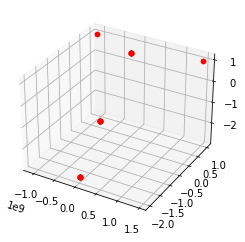

In [3]:
# print("best")
# print(best_points[0:5])
# print(best_points.T.shape)
# print("left")
# items = reducedLeft.items()
#test = np.array(list(reducedLeft.items()))
test = []
for i, j in reducedLeft.items():
    test.append([j, i])
test = np.array(test)
# print(test.T.shape)

test2 = test[0:-1:math.ceil(test.shape[0]/50)]
best_points2 = best_points[0:-1:math.ceil(best_points.shape[0]/50)]

# print(test2)
# print("dddddddddddddd")
# print(best_points2)

# print(test2[0:3])
# print(best_points2[0:3])
# print(test2.T.shape)
# print(best_points2.shape)
# print(P1)




# #-----------------------------------------Triangulation

res = cv2.triangulatePoints(P1, P2, test2.T, best_points2.T)
# print(res.shape)
# print(res[0])
#res = res/res[3]
# res = res.T
# print(res[0])


fig = plt.figure(figsize=(4,4))

ax = fig.add_subplot(111, projection='3d')

for elem in res.T:
    if elem[3] == 0:
        continue
    elem = elem/elem[3]
    print(elem)
    ax.scatter(elem[0], elem[1], elem[2], c='r', marker='o')
plt.show()